# Explore differential expression analysis results

In [19]:
import warnings
import scanpy as sc
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import time
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from scipy.sparse import csr_matrix
from scipy.stats import hypergeom

import matplotlib.cm as cm
import matplotlib.colors as mcolors 
import time


sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 100)
sc.set_figure_params(figsize=(20, 4))

In [20]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4i_final'
experiment_name = 'CD4i_final'

In [5]:
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results_corrected.h5ad')

In [21]:
de_summary_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)

In [22]:
adata_reg = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde30ntotal75_varfiltered_clustering_additional_filtering.h5ad')
adata_downstream = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde30ntotal75_varfiltered_downstream_clustering_additional_filtering.h5ad')
adata_reg.obs.rename(columns={'hdbscan':'perturbation_hdbscan'}, inplace=True)
adata_downstream.obs.rename(columns={'hdbscan':'downstream_hdbscan'}, inplace=True)
adata_downstream = adata_downstream[:,adata_reg.obs_names].copy()
adata_downstream.var = adata_reg.obs.copy()

In [23]:
adata_all = adata_downstream.T

In [24]:
adata_all

AnnData object with n_obs × n_vars = 2336 × 3173
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected', 'perturbation_hdbscan'
    var: 'gene_ids', 'gene_name', 'downstream_hdbscan'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'masked_zscore', 'p_value', 'zscore'

In [25]:
perturbation_downstream_df = pd.DataFrame(data=None, 
                                          index=adata_all.obs.perturbation_hdbscan.unique().sort_values(),
                                          columns=adata_all.var.downstream_hdbscan.unique().sort_values())
for i in perturbation_downstream_df.index:
    for j in perturbation_downstream_df.columns:
        perturbation_downstream_df.loc[i,j] = adata_all[adata_all.obs.perturbation_hdbscan==i, adata_all.var.downstream_hdbscan==j].layers['masked_zscore'].mean().item()

perturbation_downstream_df = perturbation_downstream_df.astype(float)

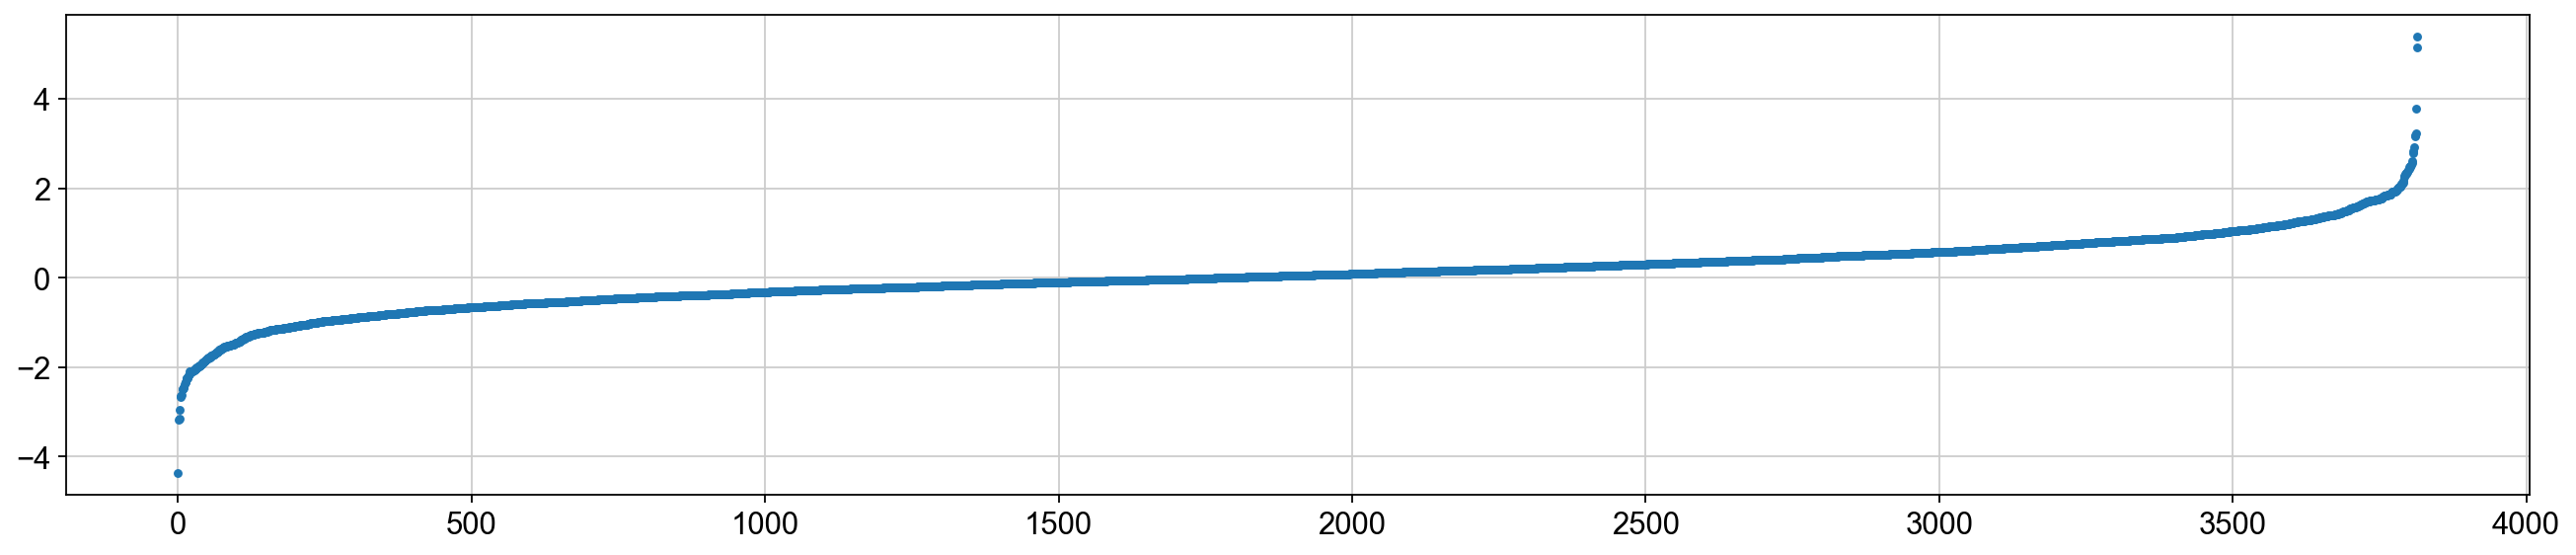

In [26]:
plt.plot(np.sort(perturbation_downstream_df.values.flatten()), '.')

In [33]:
perturbation_downstream_df.loc[10,5]

-4.379118853826759

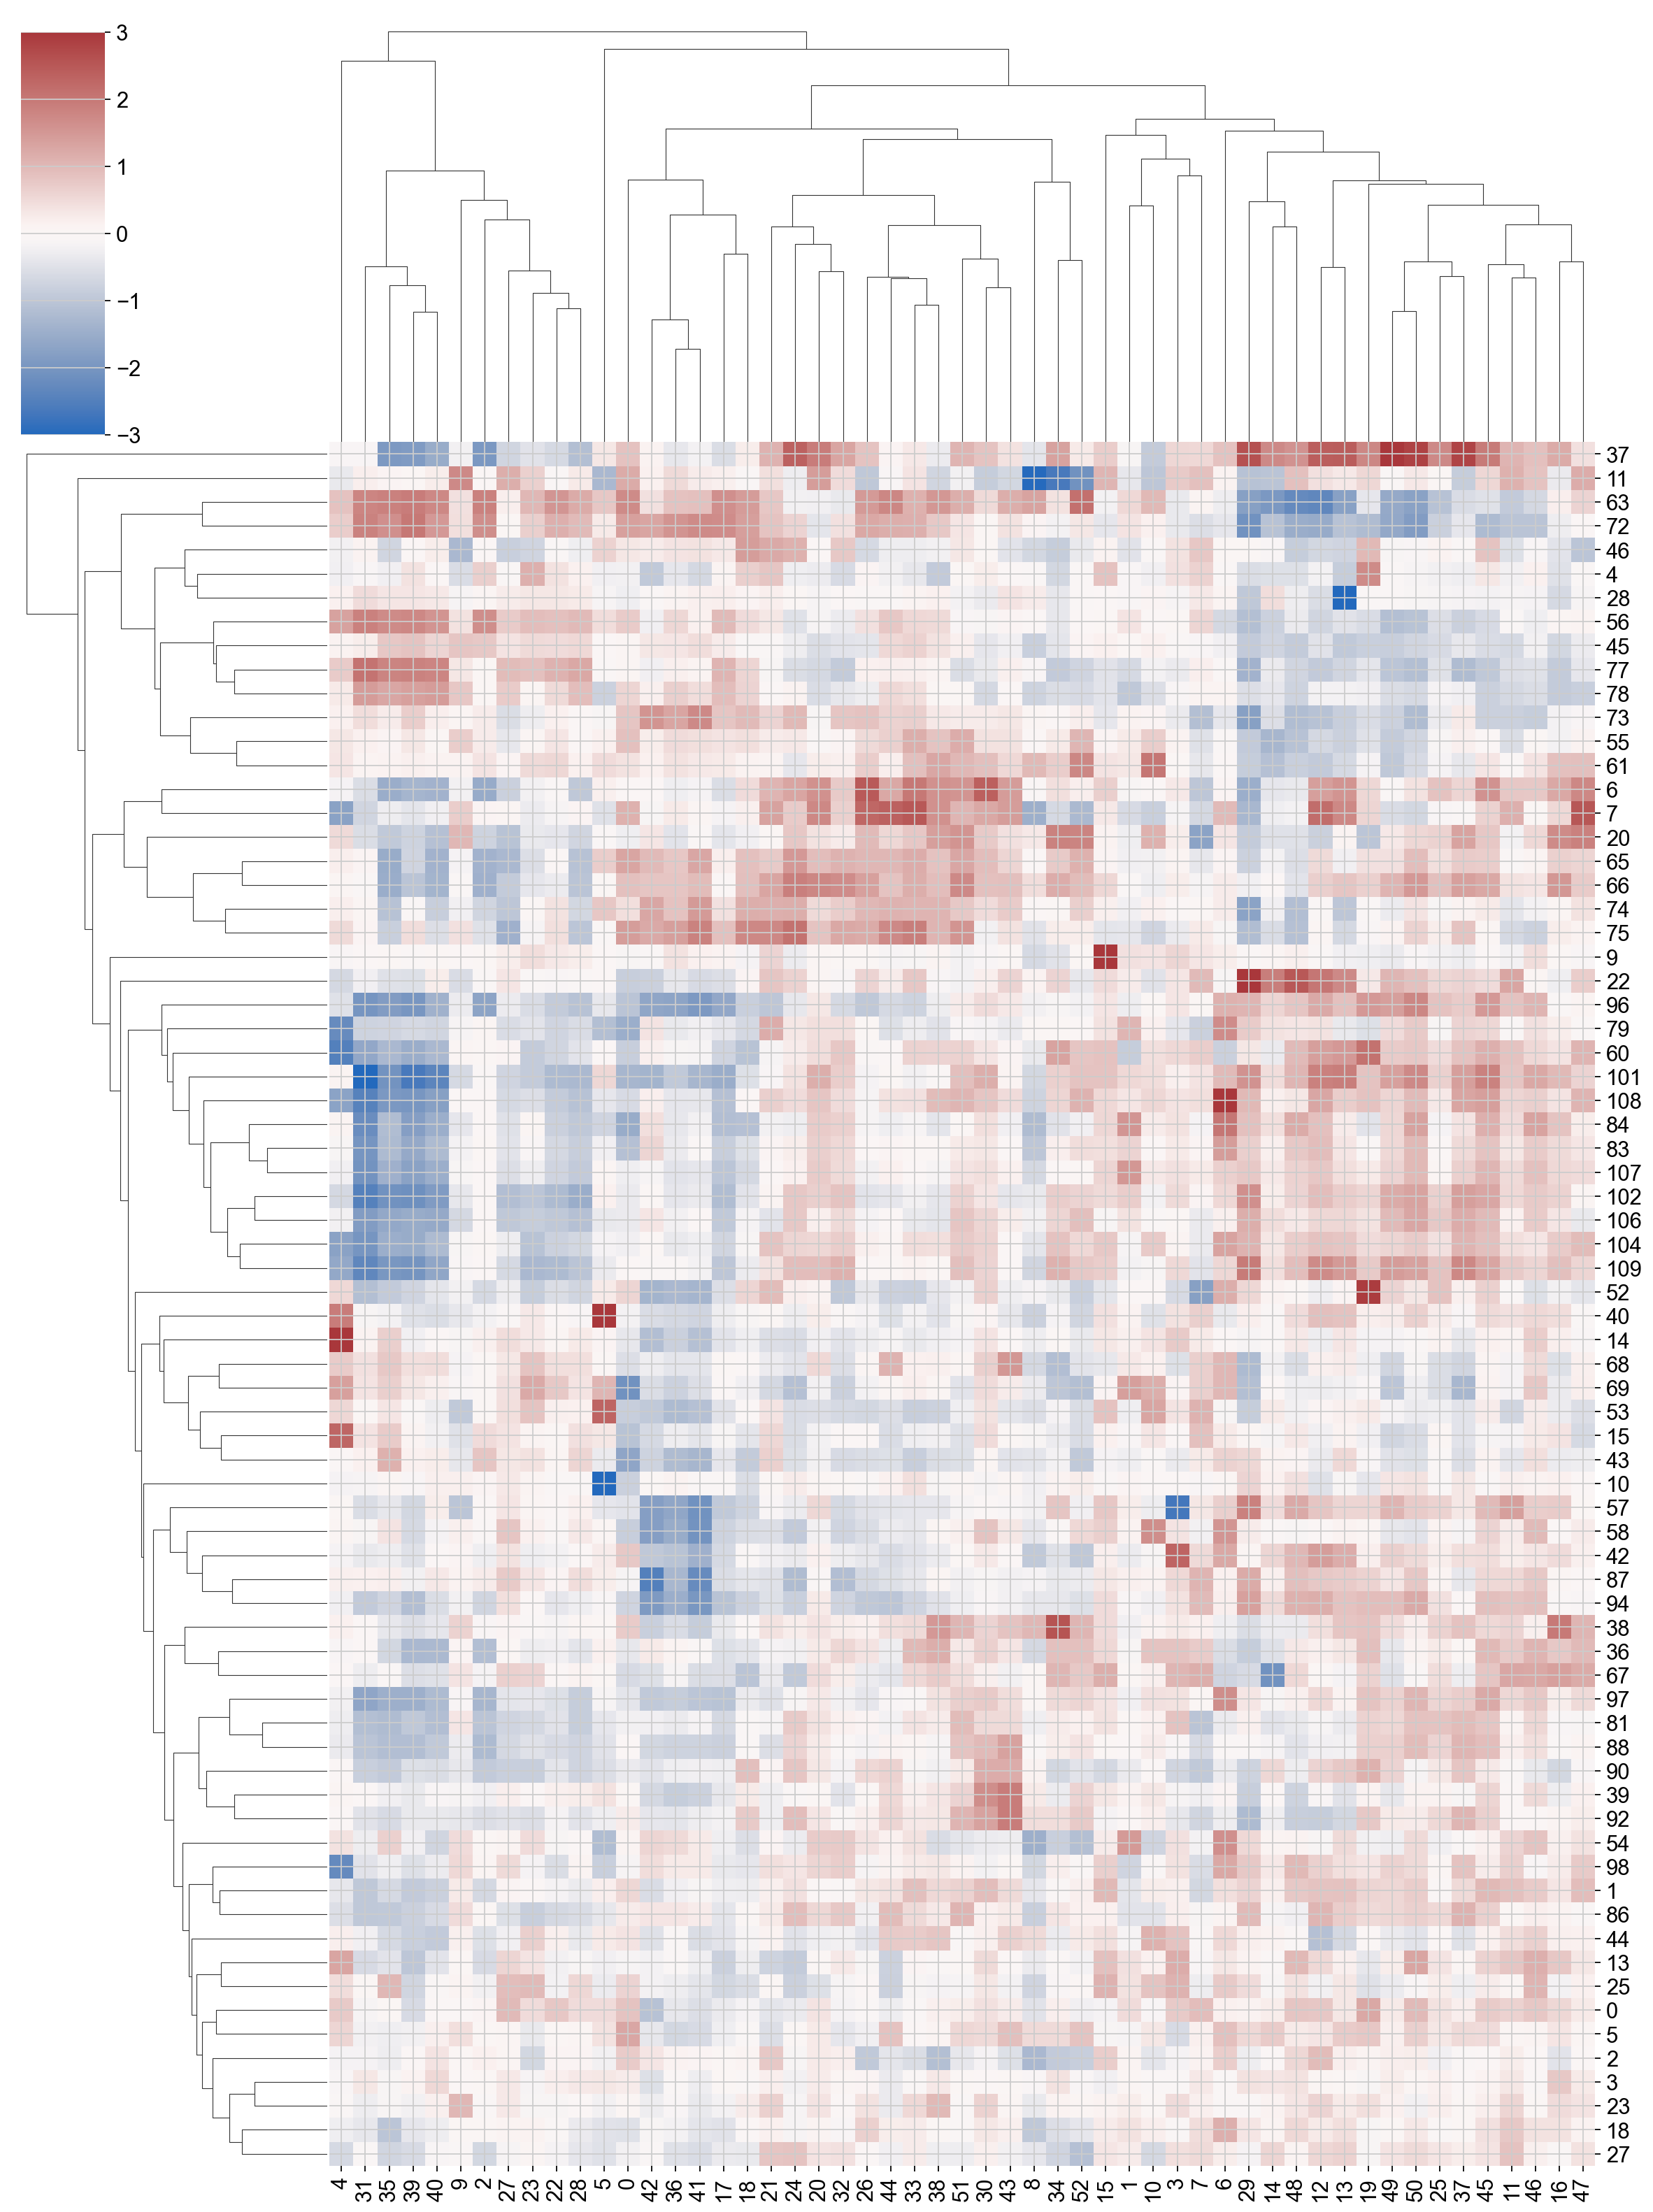

In [35]:
sns.clustermap(perturbation_downstream_df, cmap='vlag', vmin=-3, vmax=3, figsize=(15,20),
               xticklabels=perturbation_downstream_df.columns,
               yticklabels=perturbation_downstream_df.index)

plt.savefig('./results/regulator_cluster_downstream_cluster_regulation.png')

In [45]:
genelist = adata_all[adata_all.obs['perturbation_hdbscan']==101].obs.target_contrast_gene_name_corrected.tolist()

In [38]:
de_summary_stats[de_summary_stats.target_name=='MRC2']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,target_contrast_corrected,obs_names,target_name_corrected
6338,ENSG00000011028,MRC2,Rest,892.0,77,60,137,-3.931390,True,2.619969,False,>10 DE genes,on-target KD,ENSG00000011028,ENSG00000011028_Rest,MRC2
13039,ENSG00000011028,MRC2,Stim48hr,794.0,877,474,1351,-8.407177,True,21.580983,False,>10 DE genes,on-target KD,ENSG00000011028,ENSG00000011028_Stim48hr,MRC2
14639,ENSG00000011028,MRC2,Stim8hr,866.0,325,260,585,-8.376981,True,12.904244,False,>10 DE genes,on-target KD,ENSG00000011028,ENSG00000011028_Stim8hr,MRC2


In [73]:
datadir = '../../../../3_expts/processed_data'
de_by_guide = pd.read_csv('../3_DE_analysis/results/DE_by_guide.correlation_results.csv', index_col=0)
donor_robustness_summary = pd.read_csv('../3_DE_analysis/results/DE_donor_robustness_correlation_summary.csv', index_col=0)

In [74]:
donor_robustness_summary

,target_name,donor_correlation_mean,donor_correlation_min,target_contrast,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
0,A2M,0.132841,-0.214418,ENSG00000175899,Rest,366.0,56,66,122,0.000000,False,NaN,False,>10 DE genes,no on-target KD
1,A2M,0.132841,-0.214418,ENSG00000175899,Stim8hr,292.0,67,97,164,0.000000,False,NaN,False,>10 DE genes,no on-target KD
2,A2M,0.132841,-0.214418,ENSG00000175899,Stim48hr,236.0,32,13,45,0.000000,False,NaN,False,>10 DE genes,no on-target KD
3,AAGAB,0.857296,0.814893,ENSG00000103591,Stim48hr,470.0,0,1,1,-15.201199,True,78.136825,False,1 DE gene,on-target KD
4,AAGAB,0.857296,0.814893,ENSG00000103591,Rest,647.0,1,2,3,-18.512724,True,64.044124,False,2-10 DE genes,on-target KD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5054,ZSWIM4,0.274074,-0.097805,ENSG00000132003,Stim8hr,1027.0,16,3,19,-4.384355,True,1.886167,False,>10 DE genes,on-target KD
5055,ZSWIM4,0.274074,-0.097805,ENSG00000132003,Stim48hr,1178.0,16,3,19,-5.935747,True,3.730888,False,>10 DE genes,on-target KD
5056,ZSWIM9,0.422827,0.254599,ENSG00000185453,Stim8hr,620.0,0,2,2,-8.473251,True,12.677772,True,2-10 DE genes,on-target KD
5057,ZSWIM9,0.422827,0.254599,ENSG00000185453,Rest,611.0,1,2,3,-6.990321,True,9.861337,True,2-10 DE genes,on-target KD


In [46]:
de_by_guide[de_by_guide.target.isin(genelist)]

,target,correlation,correlation_ceiling,n_signif,culture_condition
25,ALG8,0.912673,0.964110,16,Rest
481,MRC2,-0.088044,NaN,217,Rest
983,ALG8,0.810166,0.907562,76,Stim8hr
1522,MRC2,0.131177,NaN,859,Stim8hr
2106,ALG8,0.361395,0.942854,19,Stim48hr
2341,ENTR1,0.942198,0.965705,5,Stim48hr
2561,MRC2,0.150769,NaN,2546,Stim48hr
2595,MTCH2,0.560722,0.864939,260,Stim48hr


In [48]:
donor_robustness_summary[donor_robustness_summary.target_name.isin(genelist)]

,target_name,donor_correlation_mean,donor_correlation_min,target_contrast,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
45,ALG8,0.569262,0.427204,ENSG00000159063,Stim8hr,711.0,355,195,550,-15.440599,True,42.465440,False,>10 DE genes,on-target KD
439,ENTR1,0.615754,0.533365,ENSG00000165689,Stim8hr,199.0,21,2,23,-8.303901,True,38.605480,False,>10 DE genes,on-target KD
838,MRC2,0.641228,0.356280,ENSG00000011028,Stim8hr,866.0,325,260,585,-8.376981,True,12.904244,False,>10 DE genes,on-target KD
885,MTCH2,0.555473,0.523792,ENSG00000109919,Stim8hr,317.0,1,1,2,-11.228738,True,47.549396,False,2-10 DE genes,on-target KD


In [49]:
genelist = ['DIMT1','EIF2AK4','EXOSC10','FBL','FBLL1','GPATCH4','NCBP2','NOC4L','NOP14',
            'NOP2','NOP56','NOP58','NOPCHAP1','PINX1','RPL7','SNU13','TGS1','UTP14C','WDR36','ZNHIT6']

In [50]:
de_summary_stats[de_summary_stats.target_name.isin(genelist)]

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,target_contrast_corrected,obs_names,target_name_corrected
1123,ENSG00000128829,EIF2AK4,Stim48hr,338.0,36,4,40,-15.359381,True,89.675034,False,>10 DE genes,on-target KD,ENSG00000128829,ENSG00000128829_Stim48hr,EIF2AK4
6315,ENSG00000160818,GPATCH4,Rest,463.0,1,1,2,-7.647329,True,33.086524,False,2-10 DE genes,on-target KD,ENSG00000160818,ENSG00000160818_Rest,GPATCH4
6404,ENSG00000128829,EIF2AK4,Rest,391.0,20,5,25,-10.177801,True,30.932379,False,>10 DE genes,on-target KD,ENSG00000128829,ENSG00000128829_Rest,EIF2AK4
14308,ENSG00000137574,TGS1,Stim8hr,103.0,15,15,30,0.000000,False,NaN,False,>10 DE genes,no on-target KD,ENSG00000137574,ENSG00000137574_Stim8hr,TGS1
14440,ENSG00000100138,SNU13,Rest,184.0,0,1,1,-9.854624,True,214.821169,False,1 DE gene,on-target KD,ENSG00000100138,ENSG00000100138_Rest,SNU13
18211,ENSG00000137574,TGS1,Rest,78.0,3,1,4,0.000000,False,NaN,False,2-10 DE genes,no on-target KD,ENSG00000137574,ENSG00000137574_Rest,TGS1
19718,ENSG00000160818,GPATCH4,Stim8hr,589.0,1,2,3,-14.577818,True,180.293905,False,2-10 DE genes,on-target KD,ENSG00000160818,ENSG00000160818_Stim8hr,GPATCH4
19725,ENSG00000171824,EXOSC10,Stim8hr,20.0,239,46,285,-3.152855,True,93.144003,False,>10 DE genes,on-target KD,ENSG00000171824,ENSG00000171824_Stim8hr,EXOSC10
21420,ENSG00000160818,GPATCH4,Stim48hr,651.0,4,1,5,-8.125592,True,43.404384,False,2-10 DE genes,on-target KD,ENSG00000160818,ENSG00000160818_Stim48hr,GPATCH4
25054,ENSG00000128829,EIF2AK4,Stim8hr,381.0,31,8,39,-12.165313,True,46.664781,False,>10 DE genes,on-target KD,ENSG00000128829,ENSG00000128829_Stim8hr,EIF2AK4


In [96]:
de_summary_stats[de_summary_stats.target_name=='VAMP3']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,target_contrast_corrected,obs_names,target_name_corrected
26890,ENSG00000049245,VAMP3,Rest,797.0,0,1,1,-15.251957,True,37.473179,False,1 DE gene,on-target KD,ENSG00000049245,ENSG00000049245_Rest,VAMP3
29872,ENSG00000049245,VAMP3,Stim48hr,699.0,1,1,2,-14.067613,True,33.193195,False,2-10 DE genes,on-target KD,ENSG00000049245,ENSG00000049245_Stim48hr,VAMP3
33737,ENSG00000049245,VAMP3,Stim8hr,703.0,0,1,1,-13.719797,True,33.097733,False,1 DE gene,on-target KD,ENSG00000049245,ENSG00000049245_Stim8hr,VAMP3


In [ ]:
['DDB2', 'PHPT1']
['PARP9', 'IFI6']**
['ITM2A', 'CD53']
['YPEL5', 'JMJD1C']**
['TMEM59', 'ATP7A']
['PSEN1', 'ATP6V0E1']
['EVI2B', 'CD247']**
['CCDC59', 'TFAM']
['VAMP3', 'VAMP4', 'COG6', 'SNAP29', 'CD3D']
['ATRX', 'SOS1', 'VAV1']
['PPP3R1', 'KLF2', 'NCAPG2']

In [64]:
adata_reg[adata_reg.obs.perturbation_hdbscan==109].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,perturbation_hdbscan
ENSG00000197442_Stim48hr,MAP3K5,Stim48hr,ENSG00000197442,7,181.0,ENSG00000197442,MAP3K5,109
ENSG00000274180_Stim48hr,NATD1,Stim48hr,ENSG00000274180,7,897.0,ENSG00000274180,NATD1,109
ENSG00000152642_Stim48hr,GPD1L,Stim48hr,ENSG00000152642,16,497.0,ENSG00000152642,GPD1L,109
ENSG00000135127_Stim48hr,BICDL1,Stim48hr,ENSG00000135127,20,680.0,ENSG00000135127,BICDL1,109
ENSG00000197223_Stim48hr,C1D,Stim48hr,ENSG00000197223,20,160.0,ENSG00000197223,C1D,109
...,...,...,...,...,...,...,...,...
ENSG00000128654_Stim48hr,MTX2,Stim48hr,ENSG00000128654,671,109.0,ENSG00000128654,MTX2,109
ENSG00000181381_Stim48hr,DDX60L,Stim48hr,ENSG00000181381,671,707.0,ENSG00000181381,DDX60L,109
ENSG00000114166_Stim48hr,KAT2B,Stim48hr,ENSG00000114166,677,786.0,ENSG00000114166,KAT2B,109
ENSG00000143867_Stim48hr,OSR1,Stim48hr,ENSG00000143867,677,438.0,ENSG00000143867,OSR1,109


In [94]:
de_summary_stats[de_summary_stats.target_name=='VAMP3']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,target_contrast_corrected,obs_names,target_name_corrected
26890,ENSG00000049245,VAMP3,Rest,797.0,0,1,1,-15.251957,True,37.473179,False,1 DE gene,on-target KD,ENSG00000049245,ENSG00000049245_Rest,VAMP3
29872,ENSG00000049245,VAMP3,Stim48hr,699.0,1,1,2,-14.067613,True,33.193195,False,2-10 DE genes,on-target KD,ENSG00000049245,ENSG00000049245_Stim48hr,VAMP3
33737,ENSG00000049245,VAMP3,Stim8hr,703.0,0,1,1,-13.719797,True,33.097733,False,1 DE gene,on-target KD,ENSG00000049245,ENSG00000049245_Stim8hr,VAMP3


In [57]:
genelist = adata_reg[adata_reg.obs.perturbation_hdbscan==101].obs['target_contrast_gene_name_corrected'].tolist()

In [88]:
len(genelist)

169

In [85]:
fortest = de_by_guide[de_by_guide.target.isin(genelist)&(de_by_guide.culture_condition=='Stim48hr')][de_by_guide[de_by_guide.target.isin(genelist)&(de_by_guide.culture_condition=='Stim48hr')].correlation>0.3].target.tolist()

In [86]:
finalfortest = donor_robustness_summary[(donor_robustness_summary.condition=='Stim48hr')&(donor_robustness_summary.target_name.isin(fortest))][donor_robustness_summary[(donor_robustness_summary.condition=='Stim48hr')&(donor_robustness_summary.target_name.isin(fortest))].donor_correlation_min>0.2].target_name.tolist()

In [87]:
finalfortest

['AASDH',
 'ADAT3',
 'ARL6IP1',
 'ATRX',
 'C1D',
 'CALCOCO2',
 'CAMSAP1',
 'CD2',
 'CD247',
 'CD28',
 'COLGALT1',
 'COPS9',
 'CREBBP',
 'CYB5R4',
 'DNAJC8',
 'DOLPP1',
 'EIF1',
 'EIF4G2',
 'ELOB',
 'EWSR1',
 'FOXM1',
 'GNE',
 'GPD1L',
 'GPI',
 'GSS',
 'HELT',
 'HTT',
 'ITK',
 'KAT2B',
 'KIF14',
 'KMT5B',
 'KNOP1',
 'L2HGDH',
 'LRP5',
 'MALT1',
 'MEN1',
 'METTL23',
 'MTX2',
 'NDFIP2',
 'NUDCD1',
 'NUP188',
 'NUP37',
 'PCNX3',
 'PEX5',
 'PHF23',
 'PLCG1',
 'PPHLN1',
 'RNF8',
 'SENP1',
 'SHOC2',
 'SIK3',
 'SOCS4',
 'STAT5A',
 'SZRD1',
 'TEAD4',
 'TMEM263',
 'TMX1',
 'TNRC6A',
 'TXNDC9',
 'UBIAD1',
 'XRRA1',
 'ZC3H10',
 'ZNF384',
 'ZNF837']